In [1]:
# @title 1. Install Dependencies & Start Kafka Server
# @markdown This step installs Java, downloads Kafka 3.6.0, and starts Zookeeper and Kafka brokers as background daemons.

import os
import time
import subprocess

# 1. Install Java and Kafka
print("☕ Installing Java...")
!apt-get install -y openjdk-11-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

print("📥 Downloading Apache Kafka...")
!wget -q https://archive.apache.org/dist/kafka/3.6.0/kafka_2.13-3.6.0.tgz
!tar -xzf kafka_2.13-3.6.0.tgz

print("🐍 Installing Python Kafka client...")
!pip install -q kafka-python pandas matplotlib

# 2. Start Zookeeper & Kafka in the background
print("🚀 Starting Zookeeper...")
subprocess.Popen(["kafka_2.13-3.6.0/bin/zookeeper-server-start.sh", "kafka_2.13-3.6.0/config/zookeeper.properties"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
time.sleep(5) # Wait for Zookeeper to warm up

print("🚀 Starting Kafka Broker...")
subprocess.Popen(["kafka_2.13-3.6.0/bin/kafka-server-start.sh", "kafka_2.13-3.6.0/config/server.properties"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
time.sleep(10) # Wait for Kafka to warm up

print("✅ Environment Ready! Kafka is running.")

☕ Installing Java...
📥 Downloading Apache Kafka...
🐍 Installing Python Kafka client...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.3/326.3 kB 9.6 MB/s eta 0:00:00
🚀 Starting Zookeeper...
🚀 Starting Kafka Broker...
✅ Environment Ready! Kafka is running.


In [2]:
# @title 2. Configuration & Topic Creation
from kafka.admin import KafkaAdminClient, NewTopic
from kafka.errors import TopicAlreadyExistsError

# Configuration
BOOTSTRAP_SERVERS = ['localhost:9092']
TOPIC_ORDER_CREATED = 'order_created'
TOPIC_PAYMENT_SUCCESS = 'payment_success'
TOPIC_PAYMENT_FAILED = 'payment_failed'
TOPIC_ORDER_SHIPPED = 'order_shipped'
TOPIC_OUT_OF_STOCK = 'out_of_stock'

def create_topics():
    admin_client = KafkaAdminClient(bootstrap_servers=BOOTSTRAP_SERVERS, client_id='admin')

    topic_list = [
        NewTopic(name=TOPIC_ORDER_CREATED, num_partitions=1, replication_factor=1),
        NewTopic(name=TOPIC_PAYMENT_SUCCESS, num_partitions=1, replication_factor=1),
        NewTopic(name=TOPIC_PAYMENT_FAILED, num_partitions=1, replication_factor=1),
        NewTopic(name=TOPIC_ORDER_SHIPPED, num_partitions=1, replication_factor=1),
        NewTopic(name=TOPIC_OUT_OF_STOCK, num_partitions=1, replication_factor=1)
    ]

    try:
        admin_client.create_topics(new_topics=topic_list, validate_only=False)
        print(f"✅ Topics created: {[t.name for t in topic_list]}")
    except TopicAlreadyExistsError:
        print("ℹ️ Topics already exist.")
    except Exception as e:
        print(f"⚠️ Error creating topics: {e}")
    finally:
        admin_client.close()

create_topics()

✅ Topics created: ['order_created', 'payment_success', 'payment_failed', 'order_shipped', 'out_of_stock']


In [3]:
# @title 3. Define Microservices (Producer & Consumers)
import json
import random
import threading
import uuid
from kafka import KafkaProducer, KafkaConsumer
from datetime import datetime

# Global flag to control simulation duration
SIMULATION_RUNNING = True

# --- Serializer Helper ---
def json_serializer(data):
    return json.dumps(data).encode('utf-8')

def json_deserializer(data):
    return json.loads(data.decode('utf-8'))

# --- Service 1: Order Generator (Producer) ---
class OrderGenerator(threading.Thread):
    def __init__(self):
        threading.Thread.__init__(self)
        self.producer = KafkaProducer(
            bootstrap_servers=BOOTSTRAP_SERVERS,
            value_serializer=json_serializer
        )

    def run(self):
        products = [
            {"item": "Laptop", "price": 1200},
            {"item": "Headphones", "price": 200},
            {"item": "Mouse", "price": 50},
            {"item": "Monitor", "price": 300}
        ]

        while SIMULATION_RUNNING:
            product = random.choice(products)
            order_id = str(uuid.uuid4())[:8]
            order = {
                "order_id": order_id,
                "item": product["item"],
                "amount": product["price"],
                "status": "CREATED",
                "timestamp": datetime.now().isoformat()
            }

            self.producer.send(TOPIC_ORDER_CREATED, order)
            print(f"🛒 [Order Service] Created Order {order_id}: {product['item']} (${product['price']})")
            time.sleep(random.uniform(0.5, 2.0)) # Simulate traffic delay

# --- Service 2: Payment Processor (Consumer -> Producer) ---
class PaymentProcessor(threading.Thread):
    def __init__(self):
        threading.Thread.__init__(self)
        self.consumer = KafkaConsumer(
            TOPIC_ORDER_CREATED,
            bootstrap_servers=BOOTSTRAP_SERVERS,
            auto_offset_reset='latest',
            value_deserializer=json_deserializer,
            group_id='payment_group'
        )
        self.producer = KafkaProducer(
            bootstrap_servers=BOOTSTRAP_SERVERS,
            value_serializer=json_serializer
        )

    def run(self):
        while SIMULATION_RUNNING:
            msg_pack = self.consumer.poll(timeout_ms=1000)
            for tp, messages in msg_pack.items():
                for message in messages:
                    order = message.value

                    # Simulate Processing Logic
                    if random.random() < 0.8: # 80% Payment Success Chance
                        order['status'] = 'PAID'
                        self.producer.send(TOPIC_PAYMENT_SUCCESS, order)
                        print(f"💳 [Payment Service] Payment Approved: {order['order_id']}")
                    else:
                        order['status'] = 'PAYMENT_FAILED'
                        self.producer.send(TOPIC_PAYMENT_FAILED, order)
                        print(f"❌ [Payment Service] Payment Declined: {order['order_id']}")

# --- Service 3: Inventory & Shipping (Consumer -> Producer) ---
class InventoryService(threading.Thread):
    def __init__(self):
        threading.Thread.__init__(self)
        self.consumer = KafkaConsumer(
            TOPIC_PAYMENT_SUCCESS,
            bootstrap_servers=BOOTSTRAP_SERVERS,
            auto_offset_reset='latest',
            value_deserializer=json_deserializer,
            group_id='inventory_group'
        )
        self.producer = KafkaProducer(
            bootstrap_servers=BOOTSTRAP_SERVERS,
            value_serializer=json_serializer
        )

    def run(self):
        while SIMULATION_RUNNING:
            msg_pack = self.consumer.poll(timeout_ms=1000)
            for tp, messages in msg_pack.items():
                for message in messages:
                    order = message.value

                    # Simulate Inventory Check
                    if random.random() < 0.9: # 90% In-Stock Chance
                        order['status'] = 'SHIPPED'
                        self.producer.send(TOPIC_ORDER_SHIPPED, order)
                        print(f"🚚 [Inventory Service] Order Shipped: {order['order_id']}")
                    else:
                        order['status'] = 'OUT_OF_STOCK'
                        self.producer.send(TOPIC_OUT_OF_STOCK, order)
                        print(f"⚠️ [Inventory Service] Out of Stock: {order['order_id']}")

# --- Service 4: Analytics Collector (Consumer) ---
class AnalyticsEngine(threading.Thread):
    def __init__(self):
        threading.Thread.__init__(self)
        self.consumer = KafkaConsumer(
            TOPIC_ORDER_CREATED, TOPIC_PAYMENT_SUCCESS, TOPIC_PAYMENT_FAILED,
            TOPIC_ORDER_SHIPPED, TOPIC_OUT_OF_STOCK,
            bootstrap_servers=BOOTSTRAP_SERVERS,
            auto_offset_reset='latest',
            value_deserializer=json_deserializer,
            group_id='analytics_group'
        )
        self.data_store = []

    def run(self):
        while SIMULATION_RUNNING:
            msg_pack = self.consumer.poll(timeout_ms=1000)
            for tp, messages in msg_pack.items():
                for message in messages:
                    record = message.value
                    record['topic'] = message.topic
                    self.data_store.append(record)

print("✅ Microservice classes defined.")

✅ Microservice classes defined.


In [4]:
# @title 4. Run Task Orchestration Simulation
# Initialize Services
order_svc = OrderGenerator()
payment_svc = PaymentProcessor()
inventory_svc = InventoryService()
analytics_svc = AnalyticsEngine()

# Start Threads
SIMULATION_RUNNING = True
print("🔄 Starting Orchestration Pipeline... (Running for 20 seconds)")
print("-" * 50)

analytics_svc.start()
inventory_svc.start()
payment_svc.start()
order_svc.start()

# Let it run
time.sleep(20)

# Graceful Shutdown
print("-" * 50)
print("🛑 Stopping Simulation...")
SIMULATION_RUNNING = False

order_svc.join()
payment_svc.join()
inventory_svc.join()
analytics_svc.join()

print("✅ Simulation Finished.")

🔄 Starting Orchestration Pipeline... (Running for 20 seconds)
--------------------------------------------------
🛒 [Order Service] Created Order ac5c9587: Monitor ($300)
🛒 [Order Service] Created Order 8a5921c7: Laptop ($1200)
🛒 [Order Service] Created Order b7ba3fb1: Mouse ($50)
🛒 [Order Service] Created Order dae02797: Laptop ($1200)
💳 [Payment Service] Payment Approved: dae02797
🚚 [Inventory Service] Order Shipped: dae02797
🛒 [Order Service] Created Order 5945fcd9: Laptop ($1200)
💳 [Payment Service] Payment Approved: 5945fcd9
⚠️ [Inventory Service] Out of Stock: 5945fcd9
🛒 [Order Service] Created Order fed8eea6: Laptop ($1200)
💳 [Payment Service] Payment Approved: fed8eea6
🚚 [Inventory Service] Order Shipped: fed8eea6
🛒 [Order Service] Created Order 63e7939c: Monitor ($300)
💳 [Payment Service] Payment Approved: 63e7939c
🚚 [Inventory Service] Order Shipped: 63e7939c
🛒 [Order Service] Created Order 118dd6fb: Laptop ($1200)
💳 [Payment Service] Payment Approved: 118dd6fb
🚚 [Inventory Se


📊 --- Simulation Statistics ---
Total Events Processed: 38
Total Completed Orders: 13
💰 Total Revenue Generated: $8050


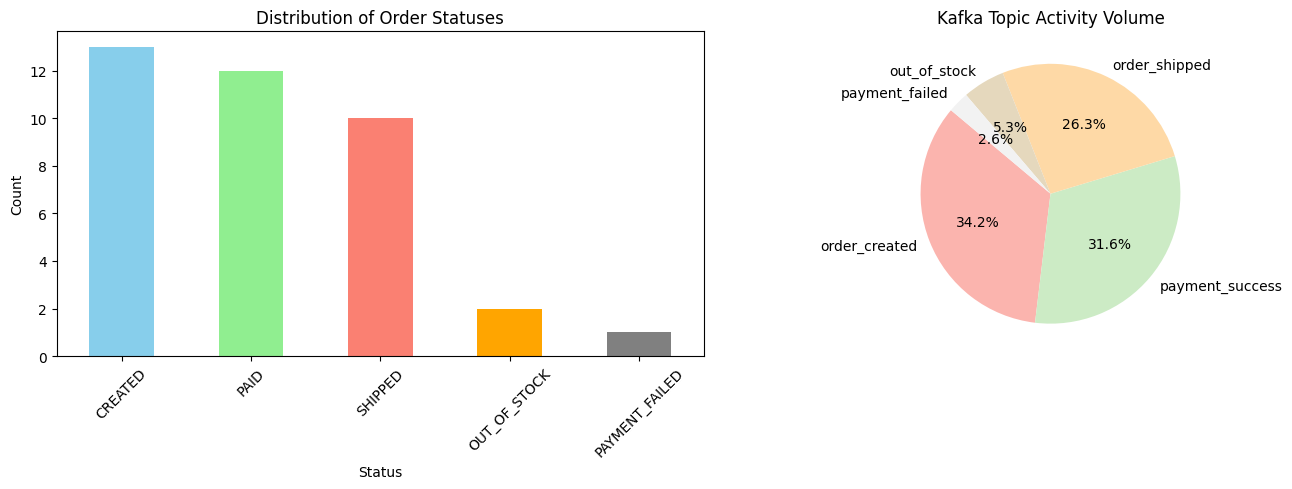


📄 Recent Data Log:
                 timestamp           topic       status order_id  amount
2026-01-04T05:22:08.248386   order_shipped      SHIPPED 74c0165c     200
2026-01-04T05:22:09.593751   order_created      CREATED 2eea77a7    1200
2026-01-04T05:22:09.593751 payment_success         PAID 2eea77a7    1200
2026-01-04T05:22:09.593751   order_shipped      SHIPPED 2eea77a7    1200
2026-01-04T05:22:10.530793   order_created      CREATED c4acd59d     300
2026-01-04T05:22:10.530793 payment_success         PAID c4acd59d     300
2026-01-04T05:22:10.530793    out_of_stock OUT_OF_STOCK c4acd59d     300
2026-01-04T05:22:11.490791   order_created      CREATED 2dd57632     300
2026-01-04T05:22:11.490791 payment_success         PAID 2dd57632     300
2026-01-04T05:22:11.490791   order_shipped      SHIPPED 2dd57632     300


In [5]:
# @title 5. Result Analysis & Visualization
import pandas as pd
import matplotlib.pyplot as plt

# Load data collected by Analytics Engine
df = pd.DataFrame(analytics_svc.data_store)

if not df.empty:
    # 1. Processing Statistics
    print("\n📊 --- Simulation Statistics ---")
    print(f"Total Events Processed: {len(df)}")

    # Filter for final statuses to see outcomes
    final_statuses = df[df['topic'].isin([TOPIC_ORDER_SHIPPED, TOPIC_OUT_OF_STOCK, TOPIC_PAYMENT_FAILED])]
    print(f"Total Completed Orders: {len(final_statuses)}")

    # Calculate Revenue (Only shipped items)
    shipped_orders = df[df['topic'] == TOPIC_ORDER_SHIPPED]
    total_revenue = shipped_orders['amount'].sum()
    print(f"💰 Total Revenue Generated: ${total_revenue}")

    # 2. Visualization
    plt.figure(figsize=(14, 5))

    # Subplot 1: Order Status Distribution
    plt.subplot(1, 2, 1)
    status_counts = df['status'].value_counts()
    status_counts.plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon', 'orange', 'grey'])
    plt.title('Distribution of Order Statuses')
    plt.xlabel('Status')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

    # Subplot 2: Events by Topic
    plt.subplot(1, 2, 2)
    topic_counts = df['topic'].value_counts()
    topic_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, cmap='Pastel1')
    plt.title('Kafka Topic Activity Volume')
    plt.ylabel('')

    plt.tight_layout()
    plt.show()

    # Display recent raw data
    print("\n📄 Recent Data Log:")
    print(df[['timestamp', 'topic', 'status', 'order_id', 'amount']].tail(10).to_string(index=False))

else:
    print("⚠️ No data collected. Did the simulation run long enough?")